# Frequencies from ray-tracing on solar model

This Jupyter notebook computes the frequencies of the standard model of the Sun (1),
first without approximation then using the ray-tracing equations of the paper of Leclerc & Laibe 2025. They are compared
to observed frequencies (2).

It uses native python libraries, and Dedalus (3) (with eigentools). Files needed:

1D solar model, fgong format "S_model.data.FGONG"

observational data points from Kiefer & Broomhall 2021 "erate_all_multiplets_online_only.dat"

References: 1) J. C.-D. et al., The current state of solar modeling. Science, 272(5266):1286–1292, 1996. 2) Kiefer, R., & Broomhall, A. M. (2021). They do change after all: 25 yr of GONG data reveal variation of p-mode energy supply rates. Monthly Notices of the Royal Astronomical Society, 500(3), 3095-3110. 3) Burns, K. J., Vasil, G. M., Oishi, J. S., Lecoanet, D., & Brown, B. P. (2020). Dedalus: A flexible framework for numerical simulations with spectral methods. Physical Review Research, 2(2), 023068.

In [1]:
### Packages

from dedalus import public as de
from eigentools import Eigenproblem
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.optimize import root_scalar
from skimage import measure
from tomso import fgong
from math import factorial
import pandas as pd
import pymp
import time

### Smoothing filer

def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [2]:
### Choice of ell
ell = 25
eps = 1/np.sqrt(ell*(ell+1))

Rin  = 0.01
Rout = 1.0

Rsun = 69.634e9

### observational data
table_path = './erate_all_multiplets_online_only.dat'
df = pd.read_table(table_path, skiprows=34, delim_whitespace=True, header=None,encoding="ISO-8859-1")
ells_obs     = df[1]
nus_obs_muHz = df[2]

n_obs_min, n_obs_max = df[ells_obs==ell][0].min(),df[ells_obs==ell][0].max()

omegas_obs = np.array(nus_obs_muHz[ells_obs==ell]*2*np.pi*1e-6)
ells_obs   = np.array(ells_obs[ells_obs==ell])

/tmp/ipykernel_1678706/790194948.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_table(table_path, skiprows=34, delim_whitespace=True, header=None,encoding="ISO-8859-1")


/tmp/ipykernel_1678706/4098318343.py:17: RuntimeWarning: invalid value encountered in divide
  S_1dmodel    = cs_1dmodel*(N2_1dmodel-(g_1dmodel/cs_1dmodel)**2)/2/g_1dmodel + cs_1dmodel/r_1dmodel -dcdr_1dmodel/2


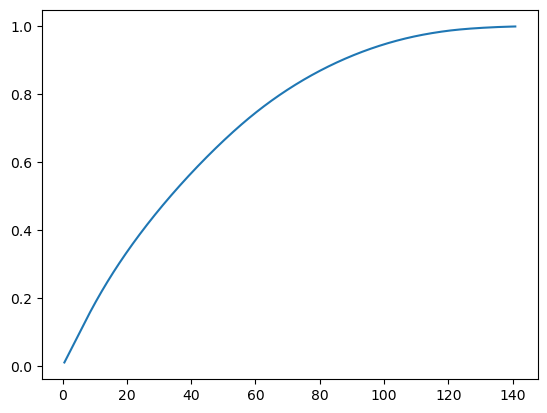

In [3]:
### Model

%matplotlib inline


model_file = 'S_model.data.FGONG'
model      = fgong.load_fgong(model_file, G=6.67232e-8)

r_1dmodel    = np.flip(model.r)
N2_1dmodel   = np.flip(model.N2)
g_1dmodel    = np.flip(model.g)
cs_1dmodel   = np.flip(model.cs)
rho_1dmodel  = np.flip(model.rho)


dcdr_1dmodel = np.gradient(cs_1dmodel,r_1dmodel)
S_1dmodel    = cs_1dmodel*(N2_1dmodel-(g_1dmodel/cs_1dmodel)**2)/2/g_1dmodel + cs_1dmodel/r_1dmodel -dcdr_1dmodel/2
cs_1dmodel   = cs_1dmodel/r_1dmodel[-1] #adim of lengths
g_1dmodel    = g_1dmodel/r_1dmodel[-1]  #adim of lengths
r_1dmodel    = r_1dmodel/r_1dmodel[-1]  #adim of lengths
z_1dmodel    = eps*np.array( [np.trapz(1/cs_1dmodel[:i],x=r_1dmodel[:i]) for i in range(len(r_1dmodel)) ])

i_in, i_out = np.argmin(np.abs(r_1dmodel - Rin)), np.argmin(np.abs(r_1dmodel - Rout))

r_1dmodel = r_1dmodel[i_in:i_out]
z_1dmodel = z_1dmodel[i_in:i_out]
cs_fit    = interpolate.interp1d(r_1dmodel,cs_1dmodel[i_in:i_out])
dcdr_fit = interpolate.interp1d(r_1dmodel,dcdr_1dmodel[i_in:i_out])
N2_fit   = interpolate.interp1d(r_1dmodel,N2_1dmodel[i_in:i_out])
S_fit    = interpolate.interp1d(r_1dmodel,S_1dmodel[i_in:i_out])
g_fit    = interpolate.interp1d(r_1dmodel,g_1dmodel[i_in:i_out])
rho_fit  = interpolate.interp1d(r_1dmodel,rho_1dmodel[i_in:i_out])
N_fit    = interpolate.interp1d(r_1dmodel,np.sqrt( np.maximum(N2_1dmodel[i_in:i_out],0) ))
z_fit    = interpolate.interp1d(r_1dmodel,z_1dmodel)
r_fit    = interpolate.interp1d(z_1dmodel,r_1dmodel)


plt.plot(z_1dmodel,r_fit(z_1dmodel))
plt.show()

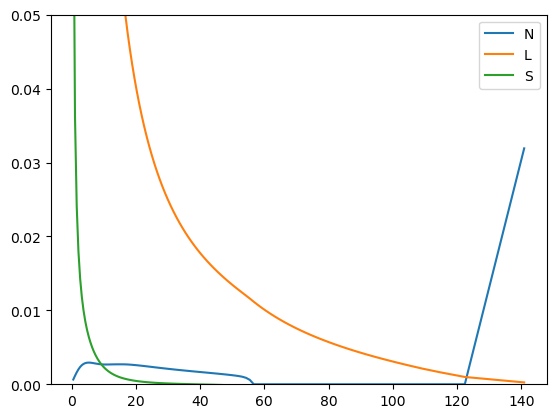

In [4]:
def N_model(r):
    return N_fit(r)

def cs_model(r):
    return cs_fit(r)

def S_model(r):
    return S_fit(r)

def L_model(r):
    return cs_fit(r)/r/eps

test = np.linspace(r_1dmodel[0],r_1dmodel[-1],100)
plt.plot(z_fit(test),N_model(test),label="N")
plt.plot(z_fit(test),L_model(test),label="L")
plt.plot(z_fit(test),S_model(test),label="S")
plt.ylim((0,5e-2))
# plt.xticks((Rin,Rout))
plt.legend()
plt.show()

## Exact frequencies of the 1D model

2025-01-16 16:47:30,955 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2025-01-16 16:47:30,982 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10


/home/alecle02/miniconda3/lib/python3.9/site-packages/eigentools/eigenproblem.py:703: RuntimeWarning: divide by zero encountered in divide
  inverse_drift = 1/self.delta_near
/home/alecle02/miniconda3/lib/python3.9/site-packages/eigentools/eigenproblem.py:733: RuntimeWarning: divide by zero encountered in divide
  ax.semilogy(mode_numbers,1/self.delta_near,'o',alpha=0.4)
/home/alecle02/miniconda3/lib/python3.9/site-packages/eigentools/eigenproblem.py:737: RuntimeWarning: divide by zero encountered in divide
  good_near = 1/self.delta_near > self.drift_threshold
/home/alecle02/miniconda3/lib/python3.9/site-packages/eigentools/eigenproblem.py:739: RuntimeWarning: divide by zero encountered in divide
  ax.semilogy(mode_numbers[good_near],1/self.delta_near[good_near],'o', label='nearest')


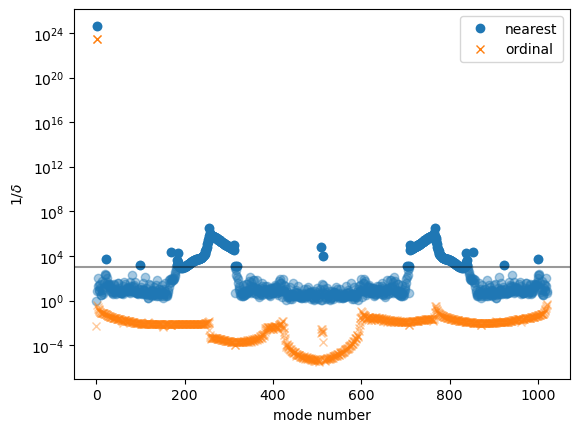

----- I find 256 modes for ℓ=25.0


In [5]:
### Dedalus solve for exact frequencies
%matplotlib inline

ℓ           = ell
Nr          = 256
driftThresh = 1e3 # only modes with frequencies converged to 1/driftThresh are kept

ells, omegas, etas, modes = [],[],[],[]

rbasis = de.Chebyshev('r', Nr, interval = (r_1dmodel[0],r_1dmodel[-1]))
domain = de.Domain([rbasis],  mesh=[1]) 
r = rbasis.grid(scale=1) #spatial points for plots

#setting up EVP problem
problem = de.EVP(domain, 
                 variables=['v','w','θ','p'], 
                 eigenvalue='σ')
problem.meta[:]['r']['dirichlet'] = True

#parameters
csound      = domain.new_field(name='cs')
csound['g'] = cs_model(r)
dcsdr       = domain.new_field(name='dcdr')
dcsdr['g']  = dcdr_fit(r)
bruntV      = domain.new_field(name='N')
bruntV['g'] = N_model(r)
strat       = domain.new_field(name='S')
strat['g']  = S_model(r)
lamb        = domain.new_field(name='Ll')
lamb['g']   = L_model(r)
problem.parameters['cs']    = csound
problem.parameters['dcdr']  = dcsdr
problem.parameters['N']     = bruntV
problem.parameters['S']     = strat
problem.parameters['Ll']    = lamb
problem.parameters['j']     = complex(0,1)

#system of eqs
problem.add_equation("-σ*(r)*v +                                 Ll*(r)*p  =  0")
problem.add_equation("-σ*w + j*N*θ -j*S*p + j*cs*dr(p)+j*dcdr*p/2  =  0")
problem.add_equation("-σ*θ - j*N*w                                 =  0")
problem.add_equation("-σ*(r)*p + Ll*(r)*v +j*(r)*S*w + j*(r)*cs*dr(w)+j*(r)*dcdr*w/2   =  0")

#BCs
problem.add_bc("left(w)  =0")
problem.add_bc("right(w) =0")

#solving
EP = Eigenproblem(problem,reject=True, drift_threshold=driftThresh, use_ordinal=False)
EP.solve(sparse=False)
EP.plot_drift_ratios()  #plot selection of "well-converged" modes
plt.show()

freqs = EP.evalues
order = range(len(freqs))
print("----- I find {} modes for ℓ={:.1f}".format(len(freqs),ℓ))

#recording results
ells_ded   =np.array([ℓ                 for i in order])
omegas_ded =np.array([np.real(freqs[i]) for i in order])
etas_ded   =np.array([np.imag(freqs[i]) for i in order])

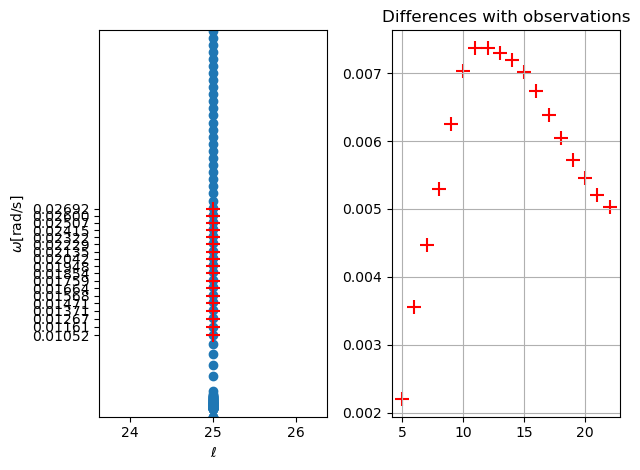

In [8]:
# plot of Dedalus solutions
%matplotlib inline
omegaMaxPlot = 0.05
fig,axs = plt.subplots(1,2)
ax=axs[0]
img = ax.scatter(ells_ded,omegas_ded)
ax.scatter(ells_obs,omegas_obs,c="red",s=100,marker="+")
ax.set_xlabel(r"$\ell$")
ax.set_ylabel(r"$\omega[\mathrm{rad/s}]$")
ax.set_ylim((0,omegaMaxPlot))
ax.set_yticks(omegas_obs)

ax=axs[1]
ax.set_title("Differences with observations")
ax.scatter(range(n_obs_min,n_obs_max+1),(omegas_ded[(omegas_ded<=1.02*omegas_obs[-1]) & (omegas_ded>=0.99*omegas_obs[0])]-omegas_obs)/omegas_obs,c="red",s=100,marker="+")

plt.grid()
plt.tight_layout()
plt.show()

# Frequencies by Bohr-sommerfeld and Duvall

In [9]:
### Phase space construction
Nz    = 512
Nkz   = 512
# choose kmax of the order of the maximum frequency you want to solve for,
# otherwise trajectories escape the phase space 
kmax  = 0.05 

# z-grid (slow acoustic radius)
z_in  = z_1dmodel[0]
z_out = z_1dmodel[-1]
z  = np.linspace(z_in,z_out,Nz)

# kz-grid 
kz   = np.linspace(-kmax,kmax,Nkz)

# meshgrid and evaluation of functions
z_m,kz_m  = np.meshgrid(z,kz)

L = L_model(r_fit(z_m))
S = S_model(r_fit(z_m))
N = N_model(r_fit(z_m))

In [10]:
### calculations of H0, Omega0, Chi0

#choice of waveband: 0 is negative p, 1 is negative g, 2 is positive g, 3 is positive p
band = 3

# H0 
j = complex(0,1)
H0 = np.zeros((kz_m.shape) + (4,4),dtype=np.complex128)


for i1 in range(kz_m.shape[0]):
    for i2 in range(kz_m.shape[1]):
        H0[i1,i2] = np.array( [[0,0,0,L[i1,i2]],
                             [0,0,-j*N[i1,i2], kz_m[i1,i2] + j*S[i1,i2]],
                             [0,j*N[i1,i2],0,0],
                             [L[i1,i2],kz_m[i1,i2]-j*S[i1,i2],0,0]]
                          ) 
        
# omega0 and chi0
eigvals, eigvecs = np.linalg.eigh(H0)
Omega0 = eigvals[:,:,band]
chi0 = eigvecs[:,:,:,band]
chi0 = chi0*np.sign(chi0[:,:,0])[:,:,None]

In [11]:
### Calculations of Omega1 and F

Omega1 = np.zeros((kz_m.shape),dtype=np.complex128)
F      = np.zeros((kz_m.shape),dtype=np.complex128)

dH0dz   = np.gradient(H0,z,axis=1,edge_order=2)
dH0dkz  = np.gradient(H0,kz,axis=0,edge_order=2)
dOm0dz  = np.gradient(Omega0,z,axis=1,edge_order=2)
dOm0dkz = np.gradient(Omega0,kz,axis=0,edge_order=2)
dchi0dz  = np.gradient(chi0,z,axis=1,edge_order=2)
dchi0dkz = np.gradient(chi0,kz,axis=0,edge_order=2)

t1 = np.zeros((kz_m.shape),dtype=np.complex128)
t2 = np.zeros((kz_m.shape),dtype=np.complex128)
t3 = np.zeros((kz_m.shape),dtype=np.complex128)
t4 = np.zeros((kz_m.shape),dtype=np.complex128)

dz,dkz = np.diff(z).mean(),np.diff(kz).mean()

for i1 in range(kz_m.shape[0]):
    for i2 in range(kz_m.shape[1]):
        #by np.gradient
        t1[i1,i2] = j/2*np.dot( chi0[i1,i2].conj(), np.dot( dH0dz[i1,i2] , dchi0dkz[i1,i2] ) )
        t2[i1,i2] = j/2*np.dot( chi0[i1,i2].conj(), np.dot( dH0dkz[i1,i2], dchi0dz[i1,i2]  ) )
        t3[i1,i2] = j/2*np.dot( chi0[i1,i2].conj(), dOm0dz[i1,i2]*dchi0dkz[i1,i2]            )
        t4[i1,i2] = j/2*np.dot( chi0[i1,i2].conj(), dOm0dkz[i1,i2]*dchi0dz[i1,i2]            )
        term1bracket = t1[i1,i2] - t3[i1,i2]
        term2bracket = t2[i1,i2] - t4[i1,i2]
        
        
        Omega1[i1,i2] = t1[i1,i2] - t3[i1,i2] - t2[i1,i2] + t4[i1,i2]
        
        F[i1,i2] = j*( np.vdot(dchi0dz[i1,i2] , dchi0dkz[i1,i2]) - np.vdot(dchi0dkz[i1,i2] , dchi0dz[i1,i2]) )

<IPython.core.display.Javascript object>


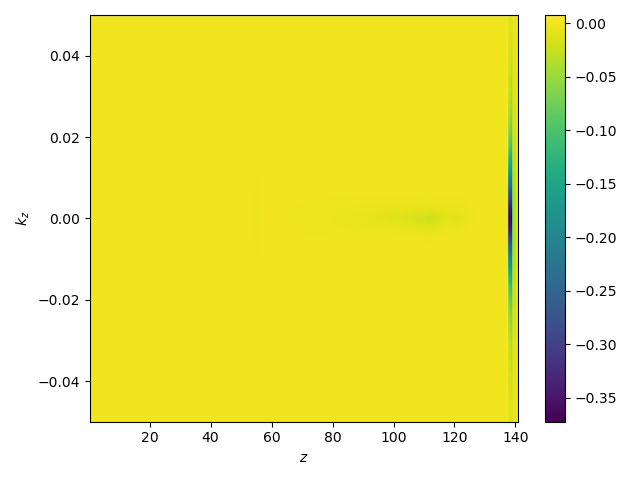

/tmp/ipykernel_1678706/524517530.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(z_m, kz_m, Omega1.real)#,vmax=10,vmin=-50)


In [16]:
%matplotlib nbAgg
fig, ax = plt.subplots()
im = ax.pcolormesh(z_m, kz_m, Omega1.real)#,vmax=10,vmin=-50) 
# im = ax.pcolormesh(z_m, kz_m, F.real,vmin=-10) 
fig.colorbar(im, ax=ax)

ax.set_xlabel(r"$z$")
ax.set_ylabel(r"$k_z$")
plt.tight_layout()
plt.show()

In [15]:
### Smoothing step: the discontinuities in the 1D model are too sharp to find closed trajectories.

Omega0_smooth = np.array([ savitzky_golay(Omega0[ikz,:],5,1)  for ikz in range(Nkz)])
F_smooth      = np.array([ savitzky_golay(F[ikz,:],5,1)  for ikz in range(Nkz)])
Omega1_smooth = np.array([ savitzky_golay(Omega1[ikz,:],5,1)  for ikz in range(Nkz)])

Omega0   = Omega0_smooth
F        = F_smooth
Omega1 = Omega1_smooth

/tmp/ipykernel_1678706/3970793443.py:68: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  window_size = np.abs(np.int(window_size))
/tmp/ipykernel_1678706/3970793443.py:69: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated i

<IPython.core.display.Javascript object>


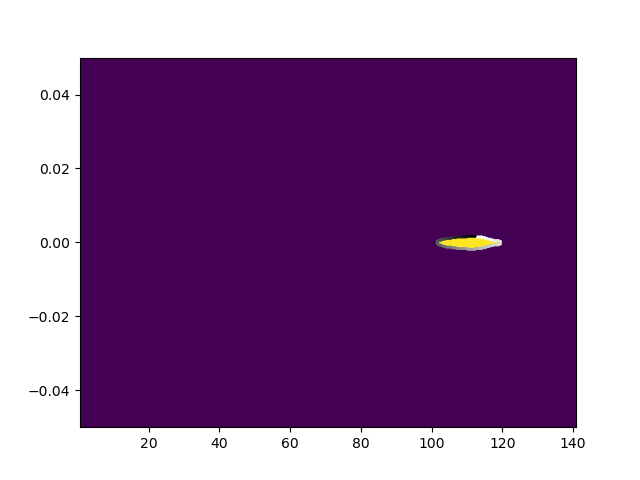

/tmp/ipykernel_1678706/3103323727.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(z_m,kz_m,sigma)


In [17]:
### Functions

# Finds the closed trajectory for omega = Omega(z,kz)
def Gamma(omega,Omega):
    contours = measure.find_contours(Omega, omega,positive_orientation="low")
    if len(contours)==0:
        return []
    elif len(contours)==1:
        contour = np.array(contours[0]).astype(int)
    elif len(contours)==2:
#         contour = np.array(contours[0].tolist()+contours[1].tolist()).astype(int)
        contour = np.array(contours[0]).astype(int)
    elif len(contours) > 2:
        return []
    return z[contour[:,1]],kz[contour[:,0]]

# Finds the surface enclosed by the closed trajectory above
def Sigma(omega,Omega):
    contour = [[0,0]]
    contours = measure.find_contours(Omega, omega)
    if len(contours)==1:
        contour = contours[0]
    elif len(contours)==2:
#         contour = np.array(contours[0].tolist()+contours[1].tolist()).astype(int)
        contour = np.array(contours[0]).astype(int)
    sigma = measure.grid_points_in_poly(Omega.shape,contour,binarize=True)
    return sigma 


omega_min = 0.99*kmax
omega_min = 0.004 # pour 50
omega_min = 0.0048 # pour 81
omega_min = 0.0051 # pour 90
omega_min = 0.0055 # pour 100
omega_min = 0.0027 # pour 30

sigma = Sigma(omega_min,Omega0+eps*Omega1.real)
plt.pcolormesh(z_m,kz_m,sigma)

zc,kzc = Gamma(omega_min,Omega0+eps*Omega1.real)
plt.scatter(zc, kzc, s=1,cmap="Greys", c = range(len(zc)))
    
plt.show()

In [19]:
### Finding frequencies for some orders

Omega = Omega0 + eps*Omega1.real  

def my_f(omega,n):
    ### the zero of this function is the frequency for vectorial ray-tracing
#     print("essaye om = ",omega)
    z_path,kz_path = Gamma(omega,Omega)
    sigma          = Sigma(omega,Omega)
    
    int_kdz = np.sum(kz_path[1:]*np.diff(z_path))
    
    berry   = np.trapz(np.trapz(F.real*sigma,x=z,axis=1),x=kz)
    
#     print("Berry n = {:} is {:}".format(n,berry))
    
    return int_kdz - eps*berry - eps*2*np.pi*(n+(0.5+0.5)*0.5)

def my_f_noBerry(omega,n):
    ### the zero of this function is the frequency when removing Berry
    z_path,kz_path = Gamma(omega,Omega)
    
    int_kdz = np.sum(kz_path[1:]*np.diff(z_path))
    
    return int_kdz - eps*2*np.pi*(n+(0.5+0.5)*0.5)


def my_f_duvall(omega,n):
    ### the zero of this function is the frequency for duvall's law
    i_z1 = np.argmin(np.abs( L[0,:] - omega ))
    i_z2 = -1
    
    z_int = z[i_z1:i_z2]
    
    integral = np.sum( np.sqrt(omega**2 - L[0,i_z1+1:i_z2]**2)*np.diff(z_int) )
    
    return (integral - eps*np.pi*(n+(0.5+0.5)*0.5))/omega**2

n = 0 done
n = 2 done
n = 3 done
n = 4 done
n = 1 done
n = 8 done
n = 7 done
n = 5 done
n = 10 done
n = 19 done
n = 6 done
n = 13 done
n = 12 done
n = 9 done
n = 17 done
n = 11 done
n = 14 done
n = 25 done
n = 21 done
n = 20 done
n = 24 done
n = 22 done
n = 29 done
n = 18 done
n = 27 done
n = 23 done
n = 30 done
n = 26 done
n = 16 done
n = 28 done
n = 15 done


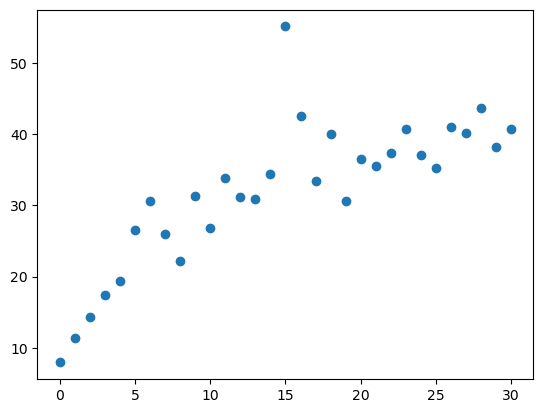

In [21]:
### Find frequencies for ray-tracing and Duvall methods
%matplotlib inline

nmin = 0 
nmax = 30

omegas_BS         = pymp.shared.array((nmax-nmin+1,), dtype=np.float64)
omegas_BS_noBerry = pymp.shared.array((nmax-nmin+1,), dtype=np.float64)
omegas_duvall     = pymp.shared.array((nmax-nmin+1,), dtype=np.float64)
times             = pymp.shared.array((nmax-nmin+1,), dtype=np.float64)


with pymp.Parallel(nmax-nmin) as p:
    for n in p.range(nmin,nmax+1):
        t0 = time.time()
        
        sol = root_scalar(my_f, args=(n), bracket=[omega_min,kmax])
        omegas_BS[n-nmin] = sol.root

        sol_noBerry =  root_scalar(my_f_noBerry, args=(n), bracket=[omega_min,kmax])
        omegas_BS_noBerry[n-nmin] = sol_noBerry.root

        sol_duvall =  root_scalar(my_f_duvall, args=(n), bracket=[0.5*omega_min,kmax])
        omegas_duvall[n-nmin] = sol_duvall.root
        
        print("n = {:} done".format(n))
        t1 = time.time()
        
        times[n-nmin] = t1-t0
        
plt.scatter(range(nmin,nmax+1),times)
plt.show()

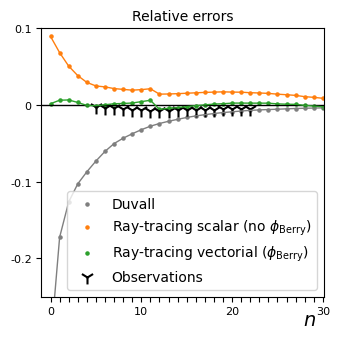

/tmp/ipykernel_1678706/1885064956.py:47: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(z_m, kz_m, F.real,cmap="Reds" )


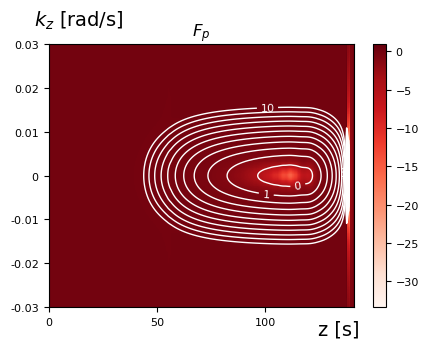

In [30]:
### final plot

omegas_ded_acoustic = omegas_ded[omegas_ded>0.003][nmin:nmax+1]

myrange             = range(nmin,nmax+1)

kmax_plot    = 0.03
nmax_plot    = 11 #number of trajectories in phase space
labels_trajs = {omegas_BS[i]:i for i in range(len(omegas_BS[:nmax_plot]))}

# ---------

fig, ax = plt.subplots(1,1,figsize=(3.5,3.5))

ax.set_title("Relative errors",fontsize=10)

ref_freqs = omegas_ded_acoustic

ax.scatter(myrange,(omegas_duvall-ref_freqs)/ref_freqs,label="Duvall",s=5,color="tab:grey")
ax.plot(myrange,(omegas_duvall-ref_freqs)/ref_freqs,lw=1,color="tab:grey")
ax.scatter(myrange,(omegas_BS_noBerry-ref_freqs)/ref_freqs,label=r"Ray-tracing scalar (no $\phi_\mathrm{Berry})$",s=5,color="tab:orange")
ax.plot(myrange,(omegas_BS_noBerry-ref_freqs)/ref_freqs,lw=1,color="tab:orange")
ax.scatter(myrange,(omegas_BS-ref_freqs)/ref_freqs,label="Ray-tracing vectorial ($\phi_\mathrm{Berry})$",s=5,color="tab:green")
ax.plot(myrange,(omegas_BS-ref_freqs)/ref_freqs,lw=1,color="tab:green")
ax.scatter(range(n_obs_min,n_obs_max+1),(omegas_obs-ref_freqs[n_obs_min:n_obs_max+1])/ref_freqs[n_obs_min:n_obs_max+1],label="Observations",s=100,c="black",marker="1")
ax.hlines((0),xmin=-1,xmax=nmax+1,color="k",lw=1)

ax.set_xlabel(r"$n$",fontsize=14)
ax.set_xlim((-1,nmax + 0.1))
ax.set_xticks(myrange)
ax.set_xticklabels((0,"","","","","","","","","",10,"","","","","","","","","",20,"","","","","","","","","",30),fontsize=8)
ax.set_yticks((-.2,-.1,0,.1,.2))
ax.set_yticklabels((-.2,-.1,0,.1,.2),fontsize=8)
ax.xaxis.set_label_coords(.95,-.05)
ax.set_ylim((-.25,.1))
ax.legend(loc=4, prop={'size': 10})

plt.tight_layout()
plt.show()

# ------------
fig, ax = plt.subplots(1,1,figsize=(4.5,3.5))

ax.set_title(r"$F_p$",fontsize=12)
CS = ax.contour(z_m, kz_m, Omega, levels=omegas_BS[:nmax_plot], colors="white",linewidths=1)
ax.clabel(CS, levels = (omegas_BS[0],omegas_BS[1],omegas_BS[nmax_plot-1]), fmt = labels_trajs, fontsize=8)
im = ax.pcolormesh(z_m, kz_m, F.real,cmap="Reds" )
cbar = fig.colorbar(im, ax=ax,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 

ax.set_xlabel(r"z [s]",fontsize=14)
ax.set_ylabel(r"$k_z$ [rad/s]",fontsize=14,rotation=0)
ax.xaxis.set_label_coords(.95,-.05)
ax.yaxis.set_label_coords(0.1, 1.05)
ax.set_xticks((0,50,100))
ax.set_xticklabels((0,50,100),fontsize=8)
ax.set_yticks((-.03,-.02,-.01,0,.01,.02,.03))
ax.set_yticklabels((-.03,-.02,-.01,0,.01,.02,.03),fontsize=8)
ax.set_ylim((-kmax_plot,kmax_plot))

plt.tight_layout()
plt.show()